# STAT 542 - Statistical Learning

# Homework 3 - Manan Mehta (mananm2)

## Due: 09/14/2020

## About HW3

In the first question, we will use a simulation study to confirm the theoretical analysis we developed during the lecture. In the second question, we will practice several linear model selection techniques such as AIC, BIC, and best subset selection. However, some difficulties are at the data processing part, in which we use the Bitcoin data from Kaggle. This is a time-series dataset, and we use the information from previous days to predict the price in a future day. Make sure that you process the data correctly to fit this task.

In [1]:
#Import all necessary packages
import numpy as np
import pandas as pd
import random
import datetime as dt
from scipy.stats import norm
from scipy.stats import uniform

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

## Question 1 (40 Points) A Simulation Study

Let's use a simulation study to confirm the bias-variance trade-off of linear regressions. Consider the following model. 

$$Y = \sum_j^p 0.9^j \times X_j + \epsilon$$

All the covariates and the error term follow i.i.d. standard Gaussian distribution. The true model involves all the variables; however, variables with larger indexes do not contribute significantly to the variation. Hence, there could be a benefit using a smaller subset for prediction purposes. Let's confirm that with a simulation study. The study essentially repeats the following steps 200 times and obtain the averaged results:

  * Generate 300 training data (both covariates and outcomes) with $p=100$, and generate another 300 outcomes as the testing data $Y$ using the same covariate value.
  * Consider using only the first $j$ variables to fit the linear regression. Let $j$ ranges from 1 to 100. Calculate and record the corresponding prediction error. 
  * For each $j$ value, we also have the theoretical analysis of the testing error based on the lecture. In that analysis, we have the formula of both the Bias$^2$ and variance. Plug-in the simulated data to calculate the Bias$^2$ and use the theoretical value for the variance. 

After finishing all simulation runs, plot your results using the `number of variables` as the x-axis, and the following 4 lines:

  * The averaged prediction error based on your 200 simulation runs
  * The averaged Bias$^2$ based on your 200 simulation runs
  * The theoretical variance 
  * The sum of Bias$^2$ + variance + Irreducible Error

Does your simulation result match our theoretical analysis? Comment on your findings.

In [2]:
beta = [0.9**j for j in range(1,101)]

prediction_error = np.zeros([200 , 100])
irreducible_error = np.zeros([200 , 100])
bias_sq = np.zeros([200 , 100])
variance = np.zeros([200 , 100])

#Outer Loop for 200 trials
for trial in range(200):
    
    #Generate training and testing data once for the given trial
    X = norm.rvs(size = (300 , 100))
    mu = X.dot(beta)
    Y_train = mu + norm.rvs(size = 300)
    Y_test  = mu + norm.rvs(size = 300)
    
    prederror = []
    irrerror = []
    bias = []
    var = []
    
    #Inner Loop to find required errors with different 'p's
    for p in range(1,101):
        
        Xtemp = X[:,:p]
        
        H = Xtemp.dot(np.linalg.inv(Xtemp.T.dot(Xtemp)).dot(Xtemp.T))
        
        Y_predicted = H.dot(Y_train)
        
        #Prediction Error = Mean Squared Error(Y_test, Y_predicted)
        prederror.append( metrics.mean_squared_error(Y_test,Y_predicted) )
        
        #Irreducible error = n*sigma^2 = n
        irrerror.append(300)
        
        #Bias Squared = ||mu - H.mu||^2
        bias.append( np.linalg.norm(mu - H.dot(mu)) ** 2 )
        
        #Theoretical variance = p*sigma^2 = p
        var.append(p)
    
    prediction_error[trial] = prederror
    irreducible_error[trial] = irrerror
    bias_sq[trial] = bias
    variance[trial] = var

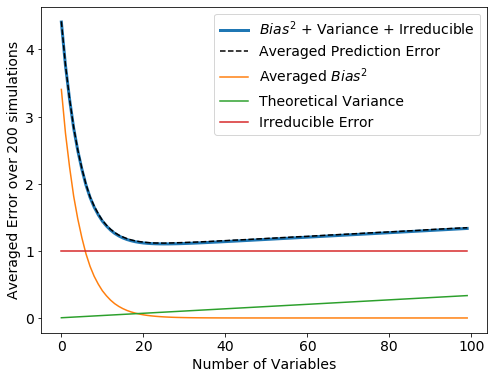

In [3]:
prediction_error_avg = np.mean(prediction_error, axis = 0)
irreducible_error_avg = np.mean(irreducible_error, axis = 0)
bias_sq_avg = np.mean(bias_sq, axis = 0)
variance_avg = np.mean(variance, axis = 0)

plt.figure(figsize = (8,6))
#Dividing all errors by 'n' which is 300 to get average error
#Not needed for prediction error as we are already calculating MSE

plt.plot((variance_avg + bias_sq_avg + irreducible_error_avg)/300, label = '$Bias^2$ + Variance + Irreducible', lw = 3)

plt.plot(prediction_error_avg, label = 'Averaged Prediction Error', ls = '--', color = 'black')

plt.plot(bias_sq_avg/300 , label = 'Averaged $Bias^2$')

plt.plot(variance_avg/300, label = 'Theoretical Variance')

plt.plot(irreducible_error_avg/300, label = 'Irreducible Error')

plt.xlabel('Number of Variables')
plt.ylabel('Averaged Error over 200 simulations')
plt.legend()

plt.show()

**Comments:**

Yes, the results agree with our theoretical findings.

(1) As expected the $Bias^2$ term decreases as the number of variables increases.

(2) We see that the theoretical variance ($p\sigma^2$) increases linearly with the number of variables.

(3) The mean squared prediction error that we calculate after fitting our linear regression almost overlaps with the sum of the $Bias^2$, Variance and the Irreducible Error. This verifies our theoretical expression:

$$ E[Test Error] = n\sigma^2 + Bias^2 + p\sigma^2$$

(4) Based on the error curve, we can infer that the best prediction error is obtained with ~ 20 covariates.

## Question 2 (60 Points) Bitcoin Price Prediction

For this question, we will use the [Bitcoin data]() provided on the course website. The data were posted originally on Kaggle ([link](https://www.kaggle.com/sudalairajkumar/cryptocurrencypricehistory?select=bitcoin_cash_price.csv)). Make sure that you read relevant information from the Kaggle website. Our data is the `bitcoin_dataset.csv` file. You should use a training/testing split such that your training data is constructed using only information up to 12/31/2016, and your testing data is constructed using only information starting from 01/01/2017. The goal of our analysis is to predict the `btc_market_price`. Since this is longitudinal data, we will use the information from previous days to predict the market price at a future day. In particular, on each calendar day (say, day 1), we use the information from three days onward (days 1, 2, and 3) to predict the market price on the 7th day. 

Hence you need to first reconstruct the data properly to fit this purpose. This is mainly to put the outcome (of day 7) and the covariates (of the previous days) into the same row. Note that for this question, you may face issues such as missing data, categorical predictors, outliers, scaling issue, computational issue, and maybe others. Use your best judgment to deal with them. There is no general ''best answer''. Hence the grading will be based on whether you provided reasoning for your decision and whether you carried out the analysis correctly.

### Data Construction (15 Points)

Data pre-processing is usually the most time-consuming and difficult part of an analysis. We will use this example as a practice. Construct your data appropriately such that further analysis can be performed. Make sure that you consider the following:

  * The data is appropriate for our analysis goal: each row contains the outcome on the seventh day and the covariates of the first three days
  * Missing data is addressed (you can remove variable, remove observation, impute values or propose your own method)
  * Process each single covariate/outcome by considering centering/scaling/transformation and/or removing outliers
  
For each of the above tasks, make sure that you **clearly document your choice**. In the end, provide a summary table/figure of your data. You can consider using boxplots, quantiles, histogram, or any method that is easy for readers to understand. You are required to pick at least one method to present.

**Missing Data**

We use a forward fill to fill-in the missing data, which is only found in the `btc_trade_volume` covariate.

In [4]:
#We use 'csv_df' as the dataframe to store our CSV data
csv_df = pd.read_csv('bitcoin.csv', usecols = range(1,24)).fillna(method = 'ffill', axis = 0)

#Data from 3 days used to predict 7th day
n_days, pred_day = 3 , 7

#The quantiles before scaling
csv_df.quantile([0.25,0.5,0.75]).T.round(2)

,0.25,0.50,0.75
btc_market_price,6.77,2.363100e+02,6.039100e+02
btc_total_bitcoins,8405100.00,1.242910e+07,1.523764e+07
btc_market_cap,55605880.64,3.364730e+09,8.210042e+09
btc_trade_volume,301851.43,1.024287e+07,2.913615e+07
btc_blocks_size,777.25,1.513200e+04,5.930175e+04
btc_avg_block_size,0.02,2.000000e-01,6.900000e-01
btc_n_orphaned_blocks,0.00,0.000000e+00,0.000000e+00
btc_n_transactions_per_block,55.00,3.785000e+02,1.238570e+03
btc_median_confirmation_time,6.13,7.930000e+00,1.024000e+01
btc_hash_rate,11.70,2.640642e+04,1.097174e+06


**Scaling**

We see the quantiles in the original dataframe, which are very clearly skewed. Moreover, the covariates have a huge range mismatch. We thus use data scaling for each covariate, which scales each covariate as:

$$ \hat{X} = \frac{X - \bar{X}}{\sigma_X} $$

We note that since we use linear regression, thus, scaling the covariates does not affect our overall prediction accuracy. However, it does make the final results ($\hat{\beta}$) more interpretable. Further, scaling also speeds up the solution as it stabilizes the underlying algorithm. 

In [5]:
ss = StandardScaler()
scaled_csv_df = pd.DataFrame(ss.fit_transform(csv_df.values) , columns = csv_df.columns)

#The quantiles after scaling
scaled_csv_df.quantile([0.25,0.5,0.75]).T.round(2)

,0.25,0.50,0.75
btc_market_price,-0.37,-0.28,-0.12
btc_total_bitcoins,-0.74,0.22,0.88
btc_market_cap,-0.36,-0.27,-0.15
btc_trade_volume,-0.26,-0.23,-0.17
btc_blocks_size,-0.79,-0.47,0.52
btc_avg_block_size,-0.93,-0.44,0.93
btc_n_orphaned_blocks,-0.43,-0.43,-0.43
btc_n_transactions_per_block,-0.90,-0.43,0.82
btc_median_confirmation_time,-0.29,0.08,0.54
btc_hash_rate,-0.41,-0.40,-0.09


We see that the quantiles are much more 'well-defined' and 'in-range' after scaling the data. We can visualize this using a boxplot:

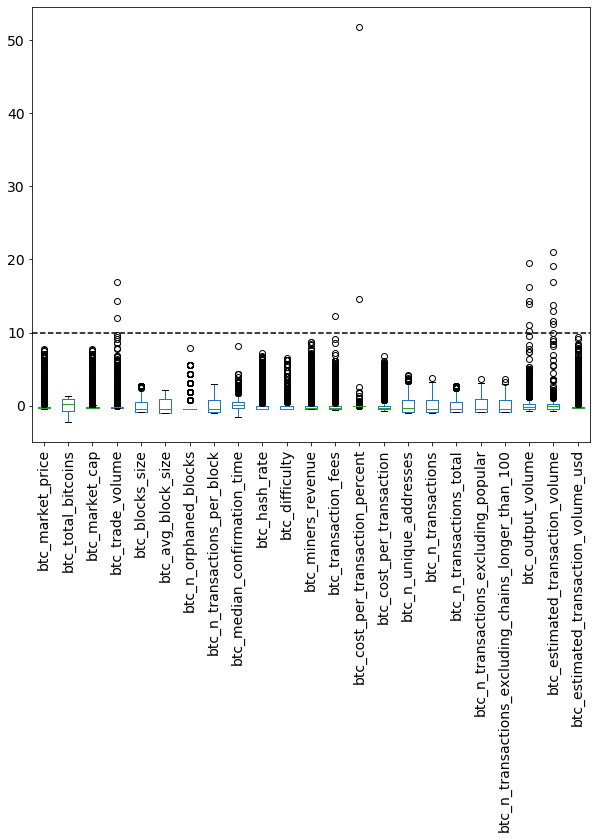

In [6]:
fig = scaled_csv_df.boxplot(figsize = (10,8), grid = False, rot = 90)
fig.axhline(10, color = 'black', ls = '--')
plt.show()

**Outliers**: 

We see that thre are quite a few outliers in the data. This is expected, since the dataset itself is massively skewed. However, any value **above 10 standard deviations can be safely neglected** as an outlier. We find that there are 20 such points, which we remove from both the original and the scaled dataset. We then plot the updated boxplot.

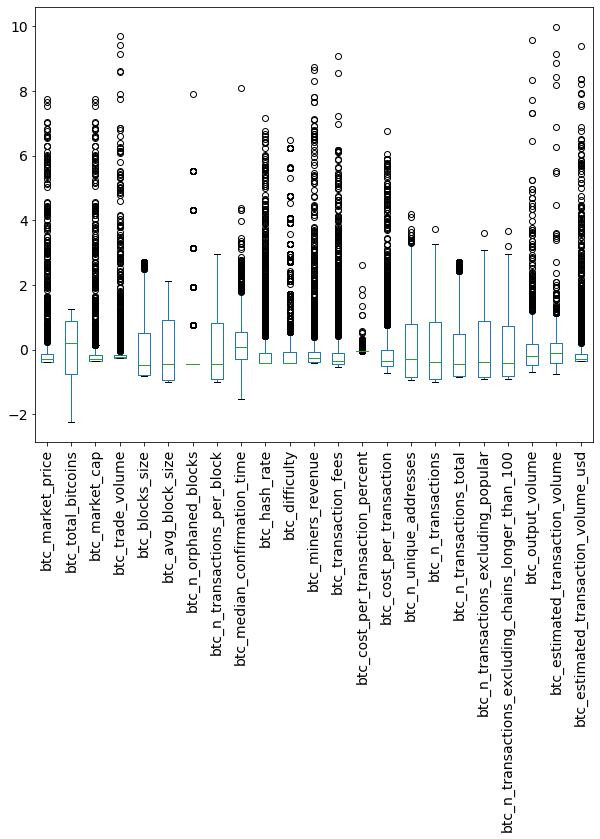

In [7]:
#Remove the outliers
outlier_idx = np.where(scaled_csv_df > 10)[0]
csv_df.drop(outlier_idx , inplace = True)
scaled_csv_df.drop(outlier_idx , inplace = True)

#Plot the final scaled data
fig = scaled_csv_df.boxplot(figsize = (10,8), grid = False, rot = 90)

**Converting the data into the analysis format**

We now convert the data into the analysis format, which is mainly to put the outcome (of day 7) and the covariates (of the previous days) into the same row.

In [8]:
#Define a new dataframe df for the preprocessed data
df = pd.DataFrame()

#Rearrage the data from each column into 3 columns, each
#with data from a day later
for i in range(len(csv_df.columns)):
    for j in range(n_days):
        df[i*n_days + j] = np.array(scaled_csv_df.iloc[j:-(pred_day-1)+j , i])

#Rename the columns of the new dataframe as:
#btc_market_price --> btc_market_price1, btc_market_price2, btc_market_price3
#and so on
df.columns = [col+str(i) for col in csv_df.columns for i in range(1,n_days+1)]

#Insert the prediction price column
df.insert(0, 'output', np.array(scaled_csv_df['btc_market_price'][(pred_day - 1):]) )

dates = np.array(pd.to_datetime(pd.read_csv('bitcoin.csv')['Date'].drop(outlier_idx))[(pred_day - 1):])
df.insert(0, 'output date', dates )

### Model Selection Criteria (15 Points)

Use AIC and BIC criteria to select the best model and report the result from each of them. Use the forward selection for AIC and backward selection for BIC. Report the following two error quantities from **both training and testing data**. 

  * The mean squared error: $n^{-1} \sum_{i}(Y_i - \widehat{Y}_i)^2$
  * The proportion of explained variation ($R^2$): $1 - \frac{\sum_{i}(Y_i - \widehat{Y}_i)^2}{\sum_{i}(Y_i - \overline{Y}_i)^2}$

Since these quantities can be affected by scaling and transformation, make sure that you **state any modifications applied to the outcome variable**. Compare the training data errors and testing data errors, which model works better? Provide a summary of your results. 

In [9]:
traindf, testdf = df[df['output date'] < '2017-01-01'] , df[df['output date'] >= '2017-01-01']
traindf.to_csv('Rtrain.csv')
testdf.to_csv('Rtest.csv')

We do not have direct models in Python to calculate AIC and BIC. Thus, the train and test dataframes were taken to R, where the R `step` function was used to find the AIC and BIC through forward and backward selection respectively.

The results are summarized as follows:

**AIC**: (Forward Selection)

Training MSE: 1.38e-04  , Testing MSE: 0.1834

Training $R^2$: 0.9879 , Testing $R^2$: 0.9483


**BIC**: (Backward Selection)

Training MSE: 1.41e-04 , Testing MSE: 0.1597

Training $R^2$: 0.9876 , Testing $R^2$: 0.955

Note that the data was standardized during preprocessing.

We see from the MSE calculations that the training MSE is lower for AIC, and the testing MSE is lower for BIC. We thus can conclude that the AIC model overfits the data, as the emphasis on penalizing the complexity is more in BIC than AIC. The BIC model works better on the testing data.

### Best Subset Selection (15 Points)

Fit the best subset selection to the dataset and report the best model of each model size (up to 7 variables, excluding the intercept) and their prediction errors. Make sure that you simplify your output so that it only presents the essential information. If the algorithm cannot handle this many variables, then consider using just day 1 and day 2 information.

We do not have direct models in Python to calculate the best subset. Thus, the train and test dataframes taken to R for model selection were processed using the R `leaps` library. (Note: The `regsubsets` function could not handle all variables and thus we use the data from day 1 and 2 only.)

The following is a summary of the results:

**Subset Size 1**: *btc_market_price_day2*

MSE: 0.1819169

**Subset Size 2**: *btc_market_price_day2 , btc_estimated_transaction_volume_usd_day2*

MSE: 0.1799706

**Subset Size 3**: *btc_market_price_day2 , btc_estimated_transaction_volume_usd_day2, btc_cost_per_transaction_day2*

MSE: 0.1800928

**Subset Size 4**: *btc_market_price_day2 , btc_estimated_transaction_volume_usd_day2, btc_n_transactions_total_day1, btc_blocks_size_day2*

MSE: 0.1816088

**Subset Size 5**: *btc_market_price_day2 , btc_estimated_transaction_volume_usd_day2, btc_n_transactions_total_day1, btc_blocks_size_day2, btc_avg_block_size_day2*

MSE: 0.1797387

**Subset Size 6**: *btc_market_price_day2 , btc_estimated_transaction_volume_usd_day2, btc_n_transactions_total_day1, btc_blocks_size_day2, btc_total_bitcoins_day2, btc_cost_per_transaction_day2*

MSE: 0.2218633

**Subset Size 7**: *btc_market_price_day2 , btc_estimated_transaction_volume_usd_day2, btc_n_transactions_total_day1, btc_blocks_size_day2, btc_total_bitcoins_day2, btc_cost_per_transaction_day2, btc_estimated_transaction_volume_usd1*

MSE: 0.2211709

### KNN (15 Points)

Use KNN to perform this prediction task. Do you expect KNN to perform better or worse than the linear model, and why? Does the analysis result match your intuition? Report your model fitting results.

We expect KNN to perform worse than the linear model. As seen from the data, the covariates are relatively closely related but the outputs are not, which causes the KNN to learn the data with a comparable accuracy of the linear regression but results in poor prediction accuracy.

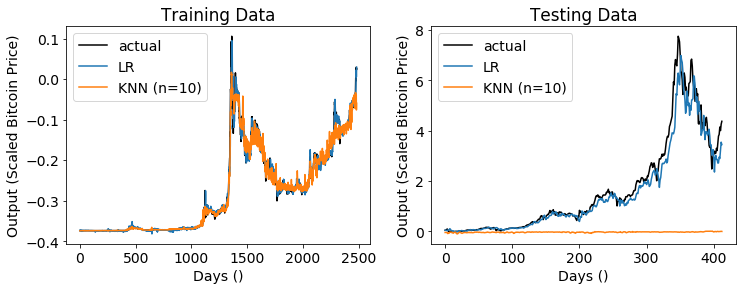

In [10]:
X_train, y_train = traindf.iloc[:,2:].values , traindf.iloc[:,1].values
X_test, y_test = testdf.iloc[:,2:].values , testdf.iloc[:,1].values
knnreg = KNeighborsRegressor(n_neighbors = 10)
linreg = LinearRegression()
knnreg.fit(X_train, y_train)
linreg.fit(X_train, y_train)
y_predicted_lin, y_predicted_knn = linreg.predict(X_test) , knnreg.predict(X_test)
y_train_predicted_lin, y_train_predicted_knn = linreg.predict(X_train) , knnreg.predict(X_train)

fig, axarr = plt.subplots(1 , 2, figsize=(12,4))
ax1, ax2 = axarr[0] , axarr[1]

ax1.plot(y_train, color = 'black', label = 'actual')
ax1.plot(y_train_predicted_lin, label = 'LR')
ax1.plot(y_train_predicted_knn, label = 'KNN (n=10)')
ax1.set_xlabel('Days ()')
ax1.set_ylabel('Output (Scaled Bitcoin Price)')
ax1.set_title('Training Data')
ax1.legend()

ax2.plot(y_test, color = 'black', label = 'actual')
ax2.plot(y_predicted_lin, label = 'LR')
ax2.plot(y_predicted_knn, label = 'KNN (n=10)')
ax2.set_xlabel('Days ()')
ax2.set_ylabel('Output (Scaled Bitcoin Price)')
ax2.set_title('Testing Data')
ax2.legend()

plt.show()

The plot above shows that the KNN and Linear Regression learn the model fairly well, but KNN has poor prediction.

From the KNN Model Fit, we have (for n = 10)

**Training Error** = 1.8e-04 (~1.2x Linear Regression)

**Testing Error** = 6.732 (~35x Linear Regression)

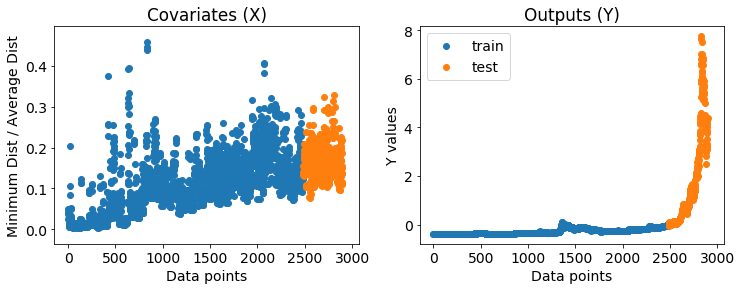

In [11]:
def get_distance_ratios(X):
    '''
    For each point in X, find the ratio minimum distance / average distance
    Inputs:
    - X : n x p vector of covariates
    
    Outputs:
    - ratiovec : n x 1 vector with each entry = min_dist/avg_dist
    '''
    n_points = X.shape[0]
    distmat = np.zeros([n_points , n_points])
    for i in range(n_points):
        for j in range(n_points):
            distmat[i,j] = np.linalg.norm(X[i] - X[j])
    
    mean = np.mean(distmat)
    
    for i in range(n_points):
        distmat[i,i] = mean
    
    ratiovec = np.zeros(n_points)
    ratiovec = np.min(distmat , axis = 1)/np.mean(distmat , axis = 1)
    
    return ratiovec

points = get_distance_ratios(df.iloc[:,2:].values)
train_points, test_points = points[:2483] , points[2483:]
fig, axarr = plt.subplots(1,2, figsize = (12, 4))

ax1, ax2 = axarr[0] , axarr[1]

ax1.scatter(range(1,len(train_points)+1) , train_points)
ax1.scatter( range(len(train_points)+1, len(train_points) + len(test_points)+1 ) , test_points)
ax1.set_title('Covariates (X)')
ax1.set_xlabel('Data points')
ax1.set_ylabel('Minimum Dist / Average Dist')

ax2.scatter(range(1,len(train_points)+1) , y_train, label = 'train')
ax2.scatter( range(len(train_points)+1, len(train_points) + len(test_points)+1 ) , y_test, label = 'test')
ax2.set_title('Outputs (Y)')
ax2.set_xlabel('Data points')
ax2.set_ylabel('Y values')

plt.legend()
plt.show()

An addition explanation for why KNN fails to perform well can be given from the plot above. The left plot shows that there is little distinction in the covariate space distances between the training and testing points, however, as seen in the right plot, the output variables are significantly different. KNN thus has poor performance.